# Equivariant Quantum Graph Neural Networks (EQGNNs)

- Verdon, G., McCourt, T., Luzhnica, E., Singh, V., Leichenauer, S., & Hidary, J. (2019). Quantum Graph Neural Networks. arXiv preprint arXiv:1909.12264. https://arxiv.org/abs/1909.12264
- Equivariant Quantum Graph Circuits: https://arxiv.org/abs/2112.05261
- Equivariant quantum circuits for learning on weighted graphs: https://www.nature.com/articles/s41534-023-00710-y
- All you need is spin: SU(2) equivariant variational quantum circuits based on spin networks: https://arxiv.org/abs/2309.07250
- Benchmarking variational quantum circuits with permutation symmetry: https://arxiv.org/pdf/2211.12711.pdf

A classical GNN maps a given graph structure into a lower dimensional vector space with characteristic features assigned to nodes and edges. This representation should preserve the topological graph structure, i.e. which nodes are connected, along with the deterministic features of the nodes and attributes of the edges. In the quantum graph structure, classical nodes can be mapped to quantum states, features to the characteristics of the states, edges to the interactions between states, and edge attributes to the strength of the interactions between the quantum states which form the graph. The larger structure of a classical model can then be embedded into the Hamiltonian operator you choose to act on the specified quantum states within the graph which will ultimately determine the dynamics and final state of the quantum algorithm. The equivariance here is introduced as a sum over the final product state elements.

## Import Packages and Device

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
!pip install particle
!pip install pennylane
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 75.3 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=e5cc5720b2c5c8c1d85fb9b5e52547459da1f52a

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
path = '/content/drive/MyDrive/research/'
directory = path
os.chdir(directory)
print(os.getcwd())

/content/drive/MyDrive/research/gsoc/2023_gsoc


In [5]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
import copy
import random

# from numpy.random import default_rng
import pandas as pd
from tqdm import tqdm
from time import time
import os
import copy
from particle import Particle
# from sklearn.model_selection import train_test_split
from gnn_egnn.preprocess import *

import torch
from torch import nn as nn
# from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import Linear
import torch.nn.functional as F
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset, download_url
# from torch_geometric.nn import GCNConv
# from torch_geometric.nn import GATConv
# from torch_geometric.nn import Sequential
# from torch_geometric import nn
# from torch_geometric.nn import global_mean_pool


torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ',device)

np.random.seed(0)
torch.manual_seed(0)

Device:  cpu


## Load Data

In [6]:
path = 'data/'
plot_path = 'plots/'

## Preprocess data

In [7]:
N=12500
x10_sorted_12500 = np.load(path+'x10_sorted_12500.npy')[:N]
y10_sorted_12500 = np.load(path+'y10_sorted_12500.npy')[:N]

In [8]:
nodes_per_graph = 3
x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help, quantum_hamiltonians = preprocess_fixed_nodes_quantum(x10_sorted_12500,y10_sorted_12500,nodes_per_graph = nodes_per_graph) #,masses[:N])
N = x_data_proc.shape[0]

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 258.05it/s]


--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---



100%|██████████| 12500/12500 [00:07<00:00, 1743.19it/s]



--- Calculating Quantum Hamiltonians ---


100%|██████████| 12500/12500 [01:11<00:00, 175.58it/s]


In [9]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data_proc.shape}')
print(f'Classification: {y_data_proc.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print(f'Quantum Information: {quantum_hamiltonians.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data_proc)}')
print(f'Classification Max: {torch.max(y_data_proc)}')
print(f'Edge Length Max: {torch.max(edge_tensor)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([12500, 3, 8])
Classification: torch.Size([12500])
Full Edge Information: torch.Size([12500, 3, 3])
Edge Index Information: torch.Size([12500, 2, 6])
Edge Attribute Information: torch.Size([12500, 6, 1])
Graph Structure Information: torch.Size([12500, 4])
Quantum Information: torch.Size([12500, 2, 8, 8])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification Max: 1
Edge Length Max: 1.0


In [10]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data_proc.shape[0]}')
print(r'Number of features per node (p_T(M),y,phi,m,E,px,py,pz): '+f'{x_data_proc.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data_proc).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,3]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data_proc[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data_proc[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 12500
Number of features per node (p_T(M),y,phi,m,E,px,py,pz): 8
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 3
Number of edges: 6.0
Average node degree: 2.00
Is undirected: True


In [11]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, hamiltonians, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.hamiltonians = hamiltonians
        self.transform  = transform

    def __len__(self):
        return self.y.shape[0]

    # Could also just define an x,y,z then pass these variables
    # in the training functions over the loop for batch (actually think that way is easier to read)
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:], #self.graph_info[index,3]],
                'x': self.x[index,:,:], #int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:], #self.graph_info[index,3]],
                'hams': self.hamiltonians[index,:,:,:],
                'y': self.y[index]  }

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [12]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)
batch_size = 1

# Create Datasets for Torch for the training and testing pahses
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:int(graph_help[i,3])],
                        x=x_data_proc[i,:int(graph_help[i,2]),:],
                        edge_attr=edge_attr_matrix[i,:int(graph_help[i,3])],
                        y=y_data_proc[i],
                        pos = quantum_hamiltonians[i,:]))

training_data = dataset[:train_index]
val_data      = dataset[train_index:val_index]
test_data     = dataset[val_index:]
# Create data loaders
train_quantum_dataloader = DataLoader(training_data,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0)

val_quantum_dataloader  = DataLoader(val_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

test_quantum_dataloader  = DataLoader(test_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

print(f'Number of training graphs: {train_index}')
print(f'Number of validation graphs: {val_index-train_index}')
print(f'Number of test graphs: {N-val_index}')

100%|██████████| 12500/12500 [00:01<00:00, 9814.07it/s] 

Number of training graphs: 10000
Number of validation graphs: 1250
Number of test graphs: 1250


In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Permutation Equivariant Quantum Graph Neural Network (EQGNN)

In [14]:
# number of qubits
qubit_number = nodes_per_graph # M*2
qubits = range(qubit_number)

In [15]:
reg1 = copy.copy([i for i in range(nodes_per_graph) ])  # load original graph

In [16]:
qubit_number

3

## EQGNN Layers

In [17]:
def state_evolve(hamiltonian, qubits, eta, q):
    U = torch.linalg.matrix_exp(-1j * eta * hamiltonian).cfloat()
    U = q@U@q.T.conj()
    qml.QubitUnitary(U, wires=qubits)

def qgcnn(inputs,weights):
    # ham_matrix1, ham_matrix2, tham_matrix1, tham_matrix2 = form_hamiltonians(graph1 = graphs[0], graph2 = graphs[1])
    # Prepares the low energy state in the two registers
    embedding_features = int(2**qubit_number)
    low_energy_state = inputs[1,:embedding_features]
    constant = torch.tensor([1.]).cfloat().to(device)
    qml.QubitStateVector(torch.kron(low_energy_state,constant), wires=reg1)
    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    inputs = inputs[0,:].reshape(batch_size,2,embedding_features,embedding_features)
    if batch_size==1:
        inputs = inputs.reshape(2,embedding_features,embedding_features)
        coeffs = weights[:,:int(n_layers*2)].reshape(n_layers,2)
        As = weights[:,int(n_layers*2):].reshape(n_layers,2,embedding_features,embedding_features)

    for j in range(coeffs.shape[0]):
      A = As[j,0,:,:].cfloat() + 1j*As[j,1,:,:].cfloat()
      I = torch.eye(A.shape[0],dtype = torch.cfloat).to(device)
      A = A + A.T.conj()
      q = (A - 1j*I)@torch.linalg.inv(A + 1j*I)
      if batch_size==1:
          state_evolve(inputs[0,:,:],  reg1, coeffs[j,0], q )
          state_evolve(inputs[1,:,:],  reg1, coeffs[j,1], q )
      else:
          state_evolve(inputs[:,0,:,:],  reg1, coeffs[j,0], q )
          state_evolve(inputs[:,1,:,:],  reg1, coeffs[j,1], q )

    return [qml.state()] # For density matrix [ qml.density_matrix(wires=[i for i in range(qubit_number) ]) ]

# Define a custom complex activation function (nn.Module)
class complex_activation(nn.Module):
    def forward(self, x):
        return nn.ReLU()(x.real) + 1.j * nn.ReLU()(x.imag)

qgcnn_dev = qml.device('default.qubit', wires=qubit_number)#, shots=shots)
# Defines the new QNode
qgcnn_qnode = qml.QNode(qgcnn,
                        device=qgcnn_dev,
                        interface = 'torch', #,#interface='torch', #interface = 'autograd'
                        diff_method='backprop')


class eigs_fn_torch(nn.Module):
    def forward(self, inputs, qstates_comp_basis):
        # Compute rotation matrices and eigenvalues
        qstates_comp_basis = qstates_comp_basis.flatten().cfloat()
        qstates_density_matrix =  qstates_comp_basis@qstates_comp_basis.T
        q,r = torch.linalg.qr(qstates_density_matrix)
        coupling_ham = (inputs[0].reshape(2,int(2**nodes_per_graph),int(2**nodes_per_graph)) )[0,:,:].cfloat()
        rotUC1 = q @ torch.linalg.matrix_exp( -1j * coupling_ham )
        UC1eigs = torch.linalg.eigvals(rotUC1)
        return qstates_comp_basis.reshape(1,qstates_comp_basis.shape[0]) #UC1eigs.reshape(1,UC1eigs.shape[0])

# Does not work because of pytorch: raises an error due to nonunique solution with phase factor e^{i phi}
class eigenvalue_decomposition(nn.Module):
    def forward(self, density_matrix):
        density_matrix = density_matrix.flatten().reshape(nodes_per_graph,2,2).cfloat()
        L,V = torch.linalg.eigh(density_matrix)
        V = V.sum(axis=0)/2**nodes_per_graph
        return V.flatten().reshape(1,V.shape[0]**2)

class qr_decomposition(nn.Module):
    def forward(self, density_matrix):
        density_matrix = density_matrix.flatten().reshape(nodes_per_graph,2,2).cfloat()
        Q,R = torch.linalg.qr(density_matrix)
        Q = Q.sum(axis=0)/2**nodes_per_graph
        return Q.flatten().reshape(1,Q.shape[0]**2)

class product_state(nn.Module):
    def forward(self, qstates_comp_basis):
        qstates_comp_basis = qstates_comp_basis.flatten().cfloat()
        return qstates_comp_basis.reshape(1,qstates_comp_basis.shape[0])

class construct_low_energy_state(nn.Module):
    def forward(self, encoded_state):
        term = torch.tensor([1.]).cfloat().to(device)
        for i in range(encoded_state.shape[0]):
            term = torch.kron(encoded_state[i,:],term)
        normalize_factor = torch.sqrt(torch.abs(torch.conj(term)@term))
        term = term/normalize_factor
        return term

## EQGNN Model

In [18]:
class quantum_iso_model(torch.nn.Module):
    def __init__(self, weight_shapes):
        super().__init__()
        # self.weights = torch.nn.Parameter(torch.randn(n_layers, gamma_and_eta))
        # self.transform = torch.nn.Identity()
        self.encoder = nn.Sequential( nn.Linear(x_data_proc.shape[2], 16, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(16, 16, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(16, 2, dtype=torch.cfloat) )

        self.qlayer = qml.qnn.TorchLayer(qgcnn_qnode, weight_shapes)
        self.eigs   = eigs_fn_torch()
        self.product_state = product_state()
        # self.eigenvalue_decomposition = eigenvalue_decomposition()
        # self.qr_decomposition = qr_decomposition()
        self.state  = construct_low_energy_state()

        self.decoder = nn.Sequential( nn.Linear(1, 6*2**qubit_number, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(6*2**qubit_number, 4*2**qubit_number, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(4*2**qubit_number, 2, dtype=torch.cfloat) )

    def forward(self, inputs, features):
        embedding = self.encoder(features)
        initial_state = self.state(embedding)
        initial_state = nn.functional.pad(initial_state, (0,inputs.shape[1]-initial_state.shape[0]), mode='constant', value=0)
        x = self.qlayer(torch.vstack([inputs,initial_state]))
        x = self.product_state(x).sum(axis=1)/x.shape[1] # sum provides permutation equivariance
        x = x.reshape(1,1)
        # x = self.eigenvalue_decomposition(x)
        # x = self.qr_decomposition(x)
        h = self.decoder(x)
        return (h*h.conj()).real

## EQGNN Training Function

In [19]:
def quantum_training(train_dataloader,
                     val_dataloader,
                     epochs,
                     loss_fn,
                     model,
                     optimizer):

    size = len(train_dataloader)
    history = { 'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}

    best_train_loss = torch.inf
    best_val_loss = torch.inf
    best_model = None
    best_train_acc = 0.
    best_val_acc = 0.
    best_auc = 0.
    best_epoch = 0
    count = 0
    current_val_loss = 0
    best_auc = 0
    size_val = len(val_dataloader)
    first_idx = torch.arange(0,size_val)
    start = time()
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, _ , _ = train(model, optimizer, epoch, train_dataloader, backprop=True)
        val_loss, val_acc, val_label, val_pred = train(model, optimizer, epoch, val_dataloader, backprop=False)

        y_score = val_pred[(first_idx,val_label.astype('int32'))]
        auc_score = roc_auc_score(val_label, y_score)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print('\n')

        if val_loss <= best_val_loss:
          best_train_loss = train_loss
          best_val_loss = val_loss
          best_train_acc = train_acc
          best_val_acc = val_acc

        if best_auc <= auc_score and epoch>=15:
          # best_model = copy.deepcopy(model)
          # best_model_wts = copy.deepcopy(model.state_dict())
          best_auc = auc_score
          print(f'Rerun and stop at epoch {epoch} to attain the best classifier.')

          # best_model = copy.deepcopy(model)
          # best_model_wts = copy.deepcopy(model.state_dict())
          # if current_val_loss>best_val_loss:
          #   count=0
          # if count==0:
          #   best_auc = auc_score
          #   current_val_loss = best_val_loss
          #   count+=1



        if epoch % 1 == 0 or epoch==epochs-1: #args.test_interval == 0:
          print("Epoch: %d |  Best Train Loss: %.8f | Best Val Loss: %.8f | Best Train Acc: %.8f | Best Val Acc: %.8f" % (epoch, best_train_loss, best_val_loss, best_train_acc, best_val_acc))
          print('Epoch: %d |  VAL AUC: %.8f \n' % (epoch, auc_score))

    end = time()
    print(f'Training Complete. Total Time (s): {end-start}')
    return {'model': best_model, 'history': history}


def train(model, optimizer, epoch, loader, backprop=True):
    size = len(loader)
    num_correct = 0
    running_loss = 0.
    loss_list = []
    if backprop:
        model.train()
    else:
        model.eval()
    all_labels = np.zeros((size,))
    all_labels_pred = np.zeros((size,2))
    for batch_idx, data in enumerate(loader):
        if batch_idx==0:
            node_size, n_feat = data[0].x.size()
        batch_size = data.x.shape[0]//node_size
        inputs = data.pos.reshape(batch_size,2*int(2**node_size)*int(2**node_size)).to(device)
        initial_node_features = data.x.cfloat().to(device)
        labels = data.y.long().reshape(batch_size,).to(device)

        labels_pred = model(inputs,initial_node_features)
        loss = loss_fn(labels_pred,labels)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        if backprop:
            loss.backward()
            optimizer.step()
        else:
          all_labels[batch_idx] = labels
          all_labels_pred[batch_idx] = labels_pred.detach().cpu()
        num_correct += (labels_pred.argmax(dim=1)==labels).sum().int()
        running_loss += loss.item()*batch_size

    accuracy = num_correct / size
    running_loss = running_loss/size

    return running_loss, accuracy, all_labels, all_labels_pred

In [20]:
seed = 3
torch.manual_seed(seed)
epochs = 19
embedding_size = 2**qubit_number
n_layers = 6
matrix_params =  n_layers*embedding_size*embedding_size*2
weight_shapes = {"weights": (1, n_layers*2 + matrix_params)}
model = quantum_iso_model(weight_shapes).to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
# print(qml.draw(qgcnn)(train_quantum_hamiltonians[0,:,:,:].flatten().cpu(), model.weights.cpu()))

In [21]:
count = 0
for i,param in enumerate(model.parameters()):
    if param.dtype==torch.complex64:
        count+=torch.view_as_real(param).flatten().shape[0]
    else:
        count+=param.flatten().shape[0]

In [22]:
print(count)

5140


In [23]:
len(train_quantum_dataloader)

10000

In [24]:
eqgnn_model_and_history = quantum_training(train_quantum_dataloader,
                             val_quantum_dataloader,
                             epochs,
                             loss_fn,
                             model,
                             optimizer)

  5%|▌         | 1/19 [09:02<2:42:36, 542.01s/it]



Epoch: 0 |  Best Train Loss: 0.59786697 | Best Val Loss: 0.58968716 | Best Train Acc: 0.68470000 | Best Val Acc: 0.69920000
Epoch: 0 |  VAL AUC: 0.22342736 



 11%|█         | 2/19 [18:07<2:34:07, 543.96s/it]



Epoch: 1 |  Best Train Loss: 0.55231741 | Best Val Loss: 0.54146681 | Best Train Acc: 0.72770000 | Best Val Acc: 0.73440000
Epoch: 1 |  VAL AUC: 0.48391933 



 16%|█▌        | 3/19 [27:22<2:26:22, 548.88s/it]



Epoch: 2 |  Best Train Loss: 0.55231741 | Best Val Loss: 0.54146681 | Best Train Acc: 0.72770000 | Best Val Acc: 0.73440000
Epoch: 2 |  VAL AUC: 0.73169360 



 21%|██        | 4/19 [36:29<2:17:02, 548.17s/it]



Epoch: 3 |  Best Train Loss: 0.55231741 | Best Val Loss: 0.54146681 | Best Train Acc: 0.72770000 | Best Val Acc: 0.73440000
Epoch: 3 |  VAL AUC: 0.57573883 



 26%|██▋       | 5/19 [45:30<2:07:19, 545.69s/it]



Epoch: 4 |  Best Train Loss: 0.54258927 | Best Val Loss: 0.54114673 | Best Train Acc: 0.73130000 | Best Val Acc: 0.73200000
Epoch: 4 |  VAL AUC: 0.50738314 



 32%|███▏      | 6/19 [54:29<1:57:46, 543.58s/it]



Epoch: 5 |  Best Train Loss: 0.54258927 | Best Val Loss: 0.54114673 | Best Train Acc: 0.73130000 | Best Val Acc: 0.73200000
Epoch: 5 |  VAL AUC: 0.67999363 



 37%|███▋      | 7/19 [1:03:17<1:47:40, 538.41s/it]



Epoch: 6 |  Best Train Loss: 0.54258927 | Best Val Loss: 0.54114673 | Best Train Acc: 0.73130000 | Best Val Acc: 0.73200000
Epoch: 6 |  VAL AUC: 0.72722162 



 42%|████▏     | 8/19 [1:12:17<1:38:46, 538.78s/it]



Epoch: 7 |  Best Train Loss: 0.54258927 | Best Val Loss: 0.54114673 | Best Train Acc: 0.73130000 | Best Val Acc: 0.73200000
Epoch: 7 |  VAL AUC: 0.43940996 



 47%|████▋     | 9/19 [1:21:12<1:29:37, 537.76s/it]



Epoch: 8 |  Best Train Loss: 0.54258927 | Best Val Loss: 0.54114673 | Best Train Acc: 0.73130000 | Best Val Acc: 0.73200000
Epoch: 8 |  VAL AUC: 0.63668056 



 53%|█████▎    | 10/19 [1:30:07<1:20:30, 536.74s/it]



Epoch: 9 |  Best Train Loss: 0.54258927 | Best Val Loss: 0.54114673 | Best Train Acc: 0.73130000 | Best Val Acc: 0.73200000
Epoch: 9 |  VAL AUC: 0.40036351 



 58%|█████▊    | 11/19 [1:39:03<1:11:33, 536.69s/it]



Epoch: 10 |  Best Train Loss: 0.54258927 | Best Val Loss: 0.54114673 | Best Train Acc: 0.73130000 | Best Val Acc: 0.73200000
Epoch: 10 |  VAL AUC: 0.38502731 



 63%|██████▎   | 12/19 [1:47:55<1:02:26, 535.15s/it]



Epoch: 11 |  Best Train Loss: 0.54258927 | Best Val Loss: 0.54114673 | Best Train Acc: 0.73130000 | Best Val Acc: 0.73200000
Epoch: 11 |  VAL AUC: 0.42347562 



 68%|██████▊   | 13/19 [1:56:44<53:19, 533.32s/it]  



Epoch: 12 |  Best Train Loss: 0.52925703 | Best Val Loss: 0.53854823 | Best Train Acc: 0.74290000 | Best Val Acc: 0.73120000
Epoch: 12 |  VAL AUC: 0.57199591 



 74%|███████▎  | 14/19 [2:05:43<44:35, 535.16s/it]



Epoch: 13 |  Best Train Loss: 0.52925703 | Best Val Loss: 0.53854823 | Best Train Acc: 0.74290000 | Best Val Acc: 0.73120000
Epoch: 13 |  VAL AUC: 0.40948975 



 79%|███████▉  | 15/19 [2:15:30<36:42, 550.73s/it]



Epoch: 14 |  Best Train Loss: 0.52925703 | Best Val Loss: 0.53854823 | Best Train Acc: 0.74290000 | Best Val Acc: 0.73120000
Epoch: 14 |  VAL AUC: 0.43538980 



 84%|████████▍ | 16/19 [2:25:02<27:51, 557.13s/it]



Rerun and stop at epoch 15 to attain the best classifier.
Epoch: 15 |  Best Train Loss: 0.52925703 | Best Val Loss: 0.53854823 | Best Train Acc: 0.74290000 | Best Val Acc: 0.73120000
Epoch: 15 |  VAL AUC: 0.59484618 



 89%|████████▉ | 17/19 [2:34:22<18:35, 557.77s/it]



Rerun and stop at epoch 16 to attain the best classifier.
Epoch: 16 |  Best Train Loss: 0.52626180 | Best Val Loss: 0.53842890 | Best Train Acc: 0.74420000 | Best Val Acc: 0.72560000
Epoch: 16 |  VAL AUC: 0.61043139 



 95%|█████████▍| 18/19 [2:43:32<09:15, 555.61s/it]



Rerun and stop at epoch 17 to attain the best classifier.
Epoch: 17 |  Best Train Loss: 0.52626180 | Best Val Loss: 0.53842890 | Best Train Acc: 0.74420000 | Best Val Acc: 0.72560000
Epoch: 17 |  VAL AUC: 0.64556293 



100%|██████████| 19/19 [2:52:43<00:00, 545.46s/it]



Rerun and stop at epoch 18 to attain the best classifier.
Epoch: 18 |  Best Train Loss: 0.52626180 | Best Val Loss: 0.53842890 | Best Train Acc: 0.74420000 | Best Val Acc: 0.72560000
Epoch: 18 |  VAL AUC: 0.75863078 

Training Complete. Total Time (s): 10363.745237827301


# Model Weights and Training History

In [25]:
train_acc = []
for i,val in enumerate(eqgnn_model_and_history['history']['train_acc']):
    train_acc.append(val.cpu().detach().numpy())

val_acc = []
for i,val in enumerate(eqgnn_model_and_history['history']['val_acc']):
    val_acc.append(val.cpu().detach().numpy())

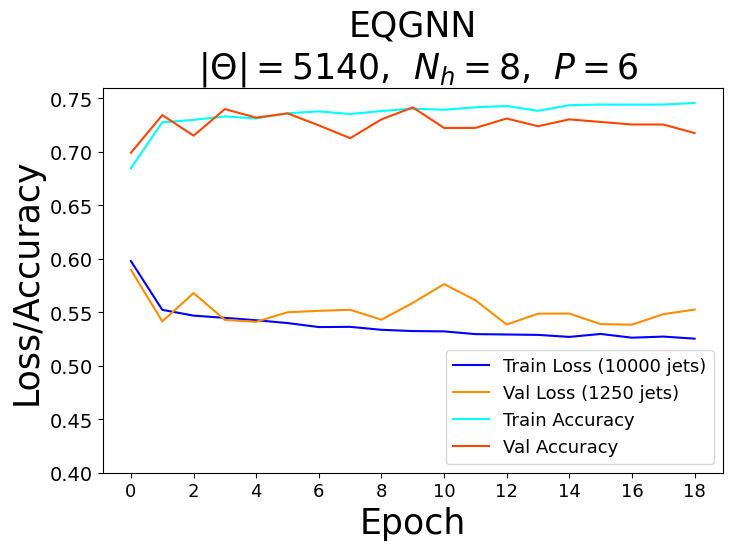

In [26]:
plt.figure(figsize=(8,5))
plt.plot(eqgnn_model_and_history['history']['train_loss'],c='b',label=f'Train Loss ({train_index} jets)')
plt.plot(eqgnn_model_and_history['history']['val_loss'],c='darkorange',label=f'Val Loss ({val_index-train_index} jets)')
plt.plot(train_acc,c='cyan',label='Train Accuracy')
plt.plot(val_acc,c='orangered',label='Val Accuracy')
plt.title(f'EQGNN\n $|\Theta| = {count}$,  $N_h={embedding_size}$,  $P={n_layers}$', fontsize=25)
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss/Accuracy',fontsize=25)
plt.legend(fontsize = 13, loc = 'lower right')
plt.xticks(fontsize=13,ticks=[i for i in range(0,epochs,2)])
plt.yticks(fontsize=14)
plt.ylim([0.40,0.76])
plt.savefig(plot_path+f'eqgnn_training_{count}_{embedding_size}_{n_layers}_{seed}.png',bbox_inches='tight')

In [27]:
model.eval()
with torch.no_grad():
    size = len(test_quantum_dataloader)
    num_correct = 0
    labels_all = None
    for i,data in enumerate(test_quantum_dataloader):
        if i==0:
            node_size, n_feat = data[0].x.size()
        batch_size = data.x.shape[0]//node_size
        inputs = data.pos.reshape(batch_size,2*int(2**node_size)*int(2**node_size)).to(device)
        labels = data.y.long().reshape(batch_size,).to(device)

        labels_pred = model(inputs,data.x.cfloat().to(device))
        num_correct += (labels_pred.argmax(dim=1)==labels).sum().int()

        if labels_all is not None:
            labels_all = torch.cat([labels_all,labels],dim=0)
            labels_pred_all = torch.cat([labels_pred_all,labels_pred],dim=0)
        else:
            labels_all = copy.deepcopy(labels)
            labels_pred_all = copy.deepcopy(labels_pred)

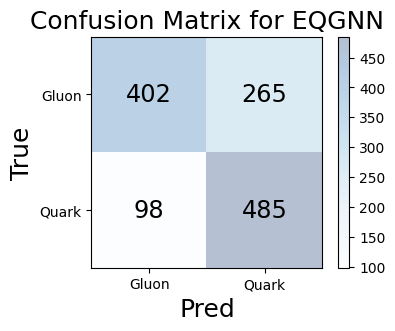

Accuracy for EQGNN:  tensor(0.7096)


In [28]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=labels_all, y_pred=labels_pred_all.argmax(dim=1))
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Pred', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix for EQGNN', fontsize=18)
plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.colorbar(im)
plt.show()

size=labels_all.shape[0]
num_correct = (labels_all==labels_pred_all.argmax(dim=1)).sum().int()
print('Accuracy for EQGNN: ',num_correct/size)

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
first_idx = torch.arange(0,labels_pred_all.shape[0])
y_score_eqgnn = labels_pred_all[(first_idx,labels_all.int())]
fpr_eqgnn, tpr_eqgnn, thresholds = roc_curve(labels_all, y_score_eqgnn)
auc_score_eqgnn = roc_auc_score(labels_all, y_score_eqgnn)

In [30]:
np.save(plot_path+f'fpr_eqgnn_{count}_{embedding_size}_{n_layers}_{seed}.npy',fpr_eqgnn)
np.save(plot_path+f'tpr_eqgnn_{count}_{embedding_size}_{n_layers}_{seed}.npy',tpr_eqgnn)
np.save(plot_path+f'y_score_eqgnn_{count}_{embedding_size}_{n_layers}_{seed}.npy',y_score_eqgnn)
np.save(plot_path+f'labels_all_eqgnn_{count}_{embedding_size}_{n_layers}_{seed}.npy',labels_all.numpy())

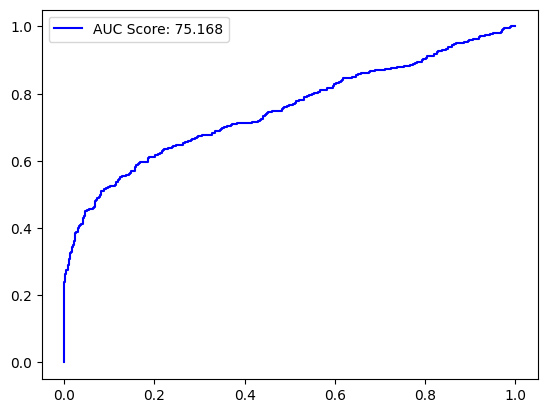

In [31]:
plt.plot(fpr_eqgnn,tpr_eqgnn,label = f'AUC Score: {100*auc_score_eqgnn:.3f}',c='b')
plt.legend()